## Setup Knowledge Base

In [1]:
from langchain_community.retrievers import WikipediaRetriever
retriever = WikipediaRetriever()


Generating knowledge base for machine learning, data science, and politics. 

In [2]:
final_docs = []
for subject in ["machine learning", "data science", "politics"]:
    docs = retriever.get_relevant_documents(query=subject)
    final_docs.extend(docs)

Let's see all documents titles in our knowledge base

In [3]:
[final_docs[i].metadata['title'] for i in range(len(final_docs))]

['Machine learning',
 'Quantum machine learning',
 'Neural network (machine learning)',
 'Data science',
 'Master in Data Science',
 'Data',
 'Politics',
 'Political party',
 'Political science']

Let's check all metadata fields

In [4]:
doc = final_docs[0]

In [5]:
print(doc.page_content[0:500])

Machine learning (ML) is a field of study in artificial intelligence concerned with the development and study of statistical algorithms that can learn from data and generalize to unseen data, and thus perform tasks without explicit instructions. Recently, artificial neural networks have been able to surpass many previous approaches in performance.Machine learning approaches have been applied to many fields including natural language processing, computer vision, speech recognition, email filterin


In [6]:
doc.metadata

{'title': 'Machine learning',
 'summary': "Machine learning (ML) is a field of study in artificial intelligence concerned with the development and study of statistical algorithms that can learn from data and generalize to unseen data, and thus perform tasks without explicit instructions. Recently, artificial neural networks have been able to surpass many previous approaches in performance.Machine learning approaches have been applied to many fields including natural language processing, computer vision, speech recognition, email filtering, agriculture, and medicine. ML is known in its application across business problems under the name predictive analytics. Although not all machine learning is statistically based, computational statistics is an important source of the field's methods.\nThe mathematical foundations of ML are provided by mathematical optimization (mathematical programming) methods. Data mining is a related (parallel) field of study, focusing on exploratory data analysis 

## Topic Modeling

Let's add topics of the document using model

In [34]:
text = doc.metadata['summary']
text

"Machine learning (ML) is a field of study in artificial intelligence concerned with the development and study of statistical algorithms that can learn from data and generalize to unseen data, and thus perform tasks without explicit instructions. Recently, artificial neural networks have been able to surpass many previous approaches in performance.Machine learning approaches have been applied to many fields including natural language processing, computer vision, speech recognition, email filtering, agriculture, and medicine. ML is known in its application across business problems under the name predictive analytics. Although not all machine learning is statistically based, computational statistics is an important source of the field's methods.\nThe mathematical foundations of ML are provided by mathematical optimization (mathematical programming) methods. Data mining is a related (parallel) field of study, focusing on exploratory data analysis (EDA) through unsupervised learning.From a

In [7]:
import openai

# Your OpenAI API key
openai.api_key = OPENAI_API_KEY

def get_topics_from_text(text):
    """
    Uses GPT-3.5 to extract topics from the provided text.
    
    :param text: The input text to analyze.
    :return: A list of topics identified in the text.
    """
    prompt = """
        Read the following text and list the 3 main topics discussed. All 3 topics should be in lower case
        and in arranged in one single string by comma separated. Space must be replaced by hyphen.

        example:
        query: "OpenAI is an artificial intelligence company which is working on text to video currently."
        output: "openai, artificial-intelligenece, text-to-video" 
    """
    
    response = openai.chat.completions.create(
        model="gpt-3.5-turbo-0125",  # Use GPT-3.5 model
        messages=[{'role':'system', 'content': prompt},
                 {"role": "user", "content": text}],
        temperature=0.1,
        top_p=1.0
    )

    # Extracting and returning the response text
    return response

In [42]:
res = get_topics_from_text(text)

In [46]:
res.choices[0].message.content

'machine-learning, artificial-intelligence, statistical-algorithms'

In [9]:
# add topics to all docs

for doc in final_docs:
    res = get_topics_from_text(doc.metadata['summary'])
    topics = res.choices[0].message.content
    doc.metadata['topics'] = topics.split(',')

In [10]:
final_docs[0].metadata

{'title': 'Machine learning',
 'summary': "Machine learning (ML) is a field of study in artificial intelligence concerned with the development and study of statistical algorithms that can learn from data and generalize to unseen data, and thus perform tasks without explicit instructions. Recently, artificial neural networks have been able to surpass many previous approaches in performance.Machine learning approaches have been applied to many fields including natural language processing, computer vision, speech recognition, email filtering, agriculture, and medicine. ML is known in its application across business problems under the name predictive analytics. Although not all machine learning is statistically based, computational statistics is an important source of the field's methods.\nThe mathematical foundations of ML are provided by mathematical optimization (mathematical programming) methods. Data mining is a related (parallel) field of study, focusing on exploratory data analysis 

## Create Knowledge Graph

In [11]:
from langchain_community.graphs import Neo4jGraph
from dotenv import load_dotenv
import os

In [12]:
load_dotenv('.env', override=True)
NEO4J_URI = os.getenv('NEO4J_URI')
NEO4J_USERNAME = os.getenv('NEO4J_USERNAME')
NEO4J_PASSWORD = os.getenv('NEO4J_PASSWORD')
NEO4J_DATABASE = os.getenv('NEO4J_DATABASE')
OPENAI_API_KEY = os.getenv('OPENAI_API_KEY')

In [13]:
kg = Neo4jGraph(
    url=NEO4J_URI, username=NEO4J_USERNAME, password=NEO4J_PASSWORD, database='neo4j'
)

In [14]:
kg.query("SHOW INDEXES")

[{'id': 1,
  'name': 'index_343aff4e',
  'state': 'ONLINE',
  'populationPercent': 100.0,
  'type': 'LOOKUP',
  'entityType': 'NODE',
  'labelsOrTypes': None,
  'properties': None,
  'indexProvider': 'token-lookup-1.0',
  'owningConstraint': None,
  'lastRead': None,
  'readCount': 0},
 {'id': 2,
  'name': 'index_f7700477',
  'state': 'ONLINE',
  'populationPercent': 100.0,
  'type': 'LOOKUP',
  'entityType': 'RELATIONSHIP',
  'labelsOrTypes': None,
  'properties': None,
  'indexProvider': 'token-lookup-1.0',
  'owningConstraint': None,
  'lastRead': None,
  'readCount': 0}]

### Creating Chunks

In [15]:
kg.query("""
CREATE CONSTRAINT unique_chunk IF NOT EXISTS 
    FOR (c:Chunk) REQUIRE c.chunkId IS UNIQUE
""")


[]

In [16]:
kg.query("SHOW INDEXES")

[{'id': 1,
  'name': 'index_343aff4e',
  'state': 'ONLINE',
  'populationPercent': 100.0,
  'type': 'LOOKUP',
  'entityType': 'NODE',
  'labelsOrTypes': None,
  'properties': None,
  'indexProvider': 'token-lookup-1.0',
  'owningConstraint': None,
  'lastRead': None,
  'readCount': 0},
 {'id': 2,
  'name': 'index_f7700477',
  'state': 'ONLINE',
  'populationPercent': 100.0,
  'type': 'LOOKUP',
  'entityType': 'RELATIONSHIP',
  'labelsOrTypes': None,
  'properties': None,
  'indexProvider': 'token-lookup-1.0',
  'owningConstraint': None,
  'lastRead': None,
  'readCount': 0},
 {'id': 3,
  'name': 'unique_chunk',
  'state': 'ONLINE',
  'populationPercent': 100.0,
  'type': 'RANGE',
  'entityType': 'NODE',
  'labelsOrTypes': ['Chunk'],
  'properties': ['chunkId'],
  'indexProvider': 'range-1.0',
  'owningConstraint': 'unique_chunk',
  'lastRead': None,
  'readCount': 0}]

In [21]:
# Common data processing
import json
import textwrap

# Langchain
from langchain_community.graphs import Neo4jGraph
from langchain_community.vectorstores import Neo4jVector
from langchain_openai import OpenAIEmbeddings
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain.chains import RetrievalQAWithSourcesChain
from langchain_openai import ChatOpenAI


# Warning control
import warnings
warnings.filterwarnings("ignore")

In [22]:
text_splitter = RecursiveCharacterTextSplitter(
    chunk_size = 2000,
    chunk_overlap  = 200,
    length_function = len,
    is_separator_regex = False,
)

def split_docs_text(final_docs):
    chunks_with_metadata = []

    for doc in final_docs: 
        print(f'Processing {doc.metadata['title']}') 
        doc_text = doc.page_content

        # split the text into chunks
        doc_text_chunks = text_splitter.split_text(doc_text) 
        chunk_seq_id = 0

        # doc metadata
        title = doc.metadata['title'].strip().replace(' ', '-')
        source = doc.metadata['source']
        topics = [t.strip() for t in doc.metadata['topics']]
        
        for chunk in doc_text_chunks:
            
            # finally, construct a record with metadata and the chunk text
            chunks_with_metadata.append({
                'text': chunk, 
                'chunkSeqId': chunk_seq_id,
                'chunkId': f'{title}-chunk{chunk_seq_id:04d}',
                'title': title,
                'source': source,
                'topics': topics,
            })
            chunk_seq_id += 1
        print(f'\tSplit into {chunk_seq_id} chunks')
    return chunks_with_metadata

### test

In [23]:
op = split_docs_text(final_docs[0:1])

Processing Machine learning
	Split into 3 chunks


In [24]:
op

[{'text': "Machine learning (ML) is a field of study in artificial intelligence concerned with the development and study of statistical algorithms that can learn from data and generalize to unseen data, and thus perform tasks without explicit instructions. Recently, artificial neural networks have been able to surpass many previous approaches in performance.Machine learning approaches have been applied to many fields including natural language processing, computer vision, speech recognition, email filtering, agriculture, and medicine. ML is known in its application across business problems under the name predictive analytics. Although not all machine learning is statistically based, computational statistics is an important source of the field's methods.\nThe mathematical foundations of ML are provided by mathematical optimization (mathematical programming) methods. Data mining is a related (parallel) field of study, focusing on exploratory data analysis (EDA) through unsupervised learn

In [25]:
chunks_with_metadata = split_docs_text(final_docs)

Processing Machine learning
	Split into 3 chunks
Processing Quantum machine learning
	Split into 3 chunks
Processing Neural network (machine learning)
	Split into 3 chunks
Processing Data science
	Split into 3 chunks
Processing Master in Data Science
	Split into 3 chunks
Processing Data
	Split into 3 chunks
Processing Politics
	Split into 3 chunks
Processing Political party
	Split into 3 chunks
Processing Political science
	Split into 4 chunks


In [26]:
len(chunks_with_metadata)

28

### Creating chunk graph nodes

In [27]:
merge_chunk_node_query = """
MERGE(mergedChunk:Chunk {chunkId: $chunkParam.chunkId})
    ON CREATE SET 
        mergedChunk.title = $chunkParam.title,
        mergedChunk.source = $chunkParam.source, 
        mergedChunk.topics = $chunkParam.topics, 
        mergedChunk.chunkSeqId = $chunkParam.chunkSeqId, 
        mergedChunk.text = $chunkParam.text
RETURN mergedChunk
"""

In [28]:
node_count = 0
for chunk in chunks_with_metadata:
    print(f"Creating `:Chunk` node for chunk ID {chunk['chunkId']}")
    kg.query(merge_chunk_node_query, 
            params={
                'chunkParam': chunk
            })
    node_count += 1
print(f"Created {node_count} nodes")

Creating `:Chunk` node for chunk ID Machine-learning-chunk0000
Creating `:Chunk` node for chunk ID Machine-learning-chunk0001
Creating `:Chunk` node for chunk ID Machine-learning-chunk0002
Creating `:Chunk` node for chunk ID Quantum-machine-learning-chunk0000
Creating `:Chunk` node for chunk ID Quantum-machine-learning-chunk0001
Creating `:Chunk` node for chunk ID Quantum-machine-learning-chunk0002
Creating `:Chunk` node for chunk ID Neural-network-(machine-learning)-chunk0000
Creating `:Chunk` node for chunk ID Neural-network-(machine-learning)-chunk0001
Creating `:Chunk` node for chunk ID Neural-network-(machine-learning)-chunk0002
Creating `:Chunk` node for chunk ID Data-science-chunk0000
Creating `:Chunk` node for chunk ID Data-science-chunk0001
Creating `:Chunk` node for chunk ID Data-science-chunk0002
Creating `:Chunk` node for chunk ID Master-in-Data-Science-chunk0000
Creating `:Chunk` node for chunk ID Master-in-Data-Science-chunk0001
Creating `:Chunk` node for chunk ID Master-

In [29]:
kg.query("""
         MATCH (n)
         RETURN count(n) as nodeCount
         """)

[{'nodeCount': 28}]

### Adding Next relationship between subsequent chunks

In [37]:
cypher = """
  MATCH (from_same_doc:Chunk)
  WHERE from_same_doc.title = $doc_title
  WITH from_same_doc
    ORDER BY from_same_doc.chunkSeqId ASC
  WITH collect(from_same_doc) as section_chunk_list
    CALL apoc.nodes.link(
        section_chunk_list, 
        "NEXT", 
        {avoidDuplicates: true}
    )
  RETURN size(section_chunk_list)
"""
for doc in final_docs:
    kg.query(cypher, params={'doc_title':doc.metadata['title'].strip().replace(' ', '-')})


### Create Doc Title Nodes

In [42]:
merge_chunk_node_query = """
MERGE(mergedTitle:Title {title : $doc_title})
    ON CREATE 
        SET mergedTitle.source = $source 
        SET mergedTitle.topics = $topics
        SET mergedTitle.summary = $summary 
"""

for doc in final_docs:
    kg.query(merge_chunk_node_query, params={'doc_title':doc.metadata['title'].strip().replace(' ', '-'),
                                            'source':doc.metadata['source'],
                                            'topics':[t.strip() for t in doc.metadata['topics']],
                                            'summary': doc.metadata['summary']
                                            })


### PART OF relationship between Doc Title and Chunks

In [43]:
cypher = """
  MATCH (c:Chunk), (t:Title)
    WHERE c.title = t.title
  MERGE (c)-[newRelationship:PART_OF]->(t)
  RETURN count(newRelationship)
"""
kg.query(cypher)

[{'count(newRelationship)': 28}]

### START relationship on first chunk of each section

In [44]:
cypher = """
  MATCH (first:Chunk), (t:Title)
  WHERE first.title = t.title
    AND first.chunkSeqId = 0
  WITH first, t
    MERGE (t)-[r:START]->(first)
  RETURN count(r)
"""

kg.query(cypher)

[{'count(r)': 9}]

### Creating Topic Nodes and assigning RELATED_TO relation

In [45]:
create_topic_relationship_query = """
UNWIND $topics AS topic
MERGE (t:Topic {name: topic})
WITH t
MATCH (title:Title {title: $doc_title})
MERGE (title)-[:RELATED_TO]->(t)
"""

for doc in final_docs:
    kg.query(create_topic_relationship_query, params={'doc_title': doc.metadata['title'].replace(' ', '-'),
                                                      'topics': [t.strip() for t in doc.metadata['topics']]})

### Adding Chunk Embeddings

Create vector index

In [48]:
kg.query("""
         CREATE VECTOR INDEX `chunks_embedding_vector` IF NOT EXISTS
          FOR (c:Chunk) ON (c.textEmbedding) 
          OPTIONS { indexConfig: {
            `vector.dimensions`: 1536,
            `vector.similarity_function`: 'cosine'    
         }}
""")

[]

In [51]:
# GenAI integration only works on Enterprise version

# kg.query("""
#     MATCH (chunk:Chunk) WHERE chunk.textEmbedding IS NULL
#     WITH chunk, genai.vector.encode(
#       chunk.text, 
#       "OpenAI", 
#       {
#         token: $openAiApiKey 
#       }) AS vector
#     CALL db.create.setNodeVectorProperty(chunk, "textEmbedding", vector)
#     """, 
#     params={"openAiApiKey":OPENAI_API_KEY} )

In [52]:
chunks = kg.query("""
            MATCH (c:Chunk) RETURN c.chunkId as chunkId, c.text AS text
        """)

In [53]:
len(chunks)

28

In [55]:
chunks[0]

{'chunkId': 'Machine-learning-chunk0000',
 'text': "Machine learning (ML) is a field of study in artificial intelligence concerned with the development and study of statistical algorithms that can learn from data and generalize to unseen data, and thus perform tasks without explicit instructions. Recently, artificial neural networks have been able to surpass many previous approaches in performance.Machine learning approaches have been applied to many fields including natural language processing, computer vision, speech recognition, email filtering, agriculture, and medicine. ML is known in its application across business problems under the name predictive analytics. Although not all machine learning is statistically based, computational statistics is an important source of the field's methods.\nThe mathematical foundations of ML are provided by mathematical optimization (mathematical programming) methods. Data mining is a related (parallel) field of study, focusing on exploratory data 

In [69]:
def get_embedding(text, model="text-embedding-3-small"):
   text = text.replace("\n", " ")
   return openai.embeddings.create(input=[text], model=model).data[0].embedding


In [70]:
embedding = get_embedding(chunks[0]['text'])

In [72]:
len(embedding)

1536

In [73]:
embedding[0:5]

[-0.040258996188640594,
 -0.023065051063895226,
 0.041978392750024796,
 -0.010242979042232037,
 0.05447545647621155]

In [75]:
set_embedding_query = """
    MATCH (c:Chunk {chunkId: $chunkId})
    SET c.textEmbedding = $embedding
"""

for c in chunks:
    kg.query(set_embedding_query, params={'chunkId':c['chunkId'], 'embedding':get_embedding(c['text'])})
    

## Checking Graph

In [76]:
kg.refresh_schema()
print(textwrap.fill(kg.schema, 60))

Node properties are the following: Chunk {title: STRING,
textEmbedding: LIST, chunkId: STRING, source: STRING,
topics: LIST, chunkSeqId: INTEGER, text: STRING},Title
{title: STRING, source: STRING, topics: LIST, summary:
STRING},Topic {name: STRING} Relationship properties are the
following:  The relationships are the following: (:Chunk)-
[:NEXT]->(:Chunk),(:Chunk)-[:PART_OF]->(:Title),(:Title)-
[:RELATED_TO]->(:Topic),(:Title)-[:START]->(:Chunk)


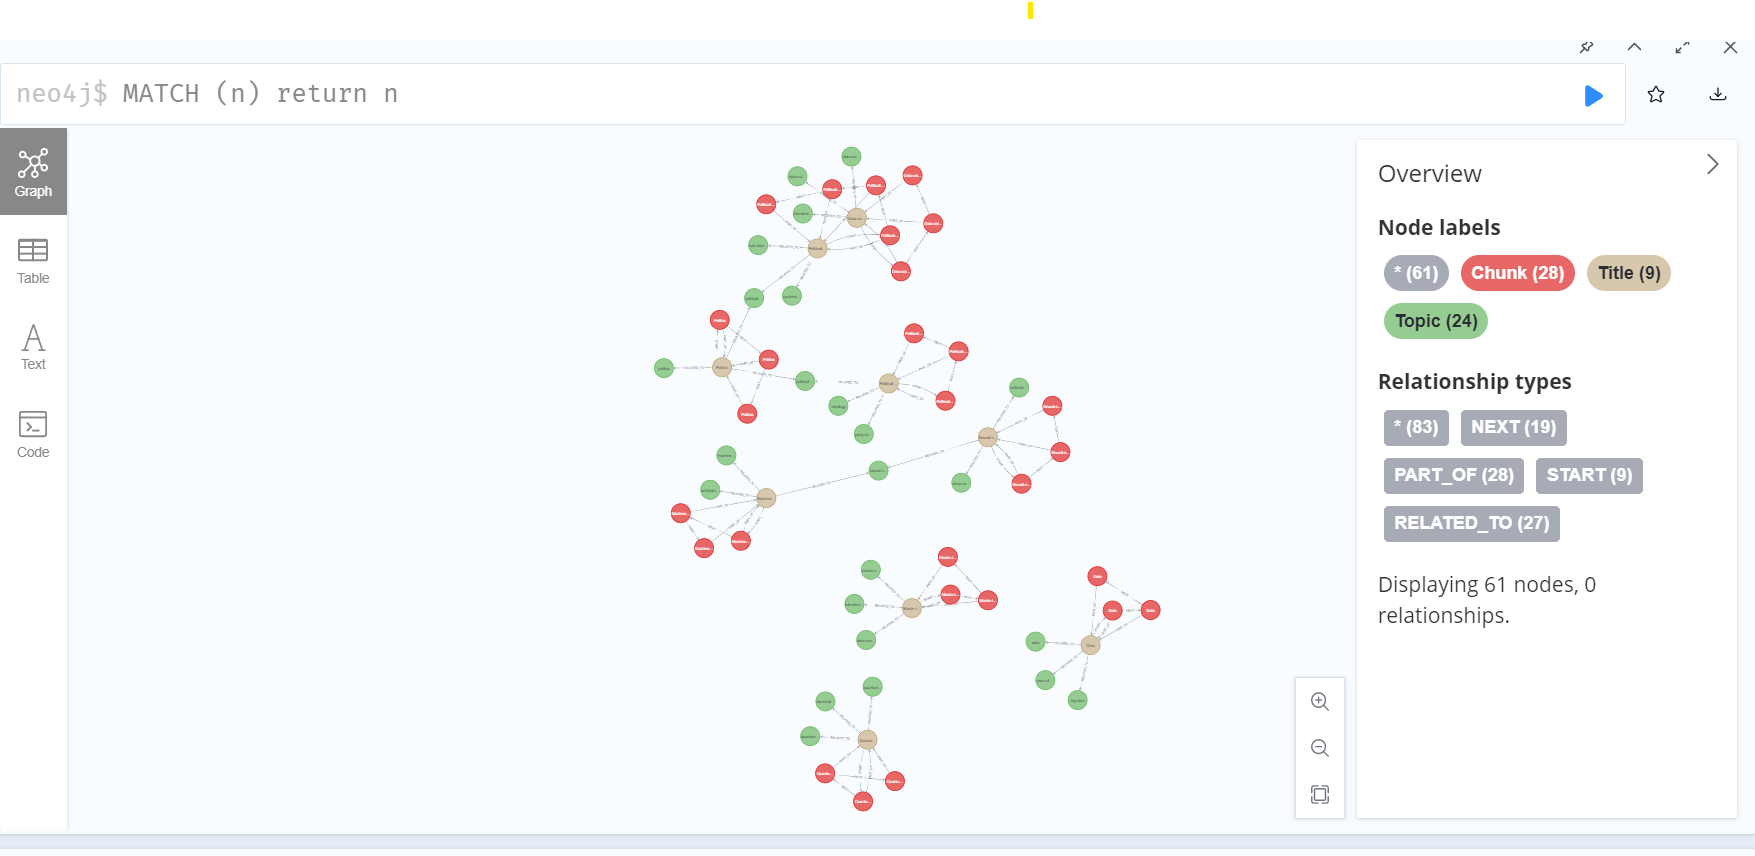

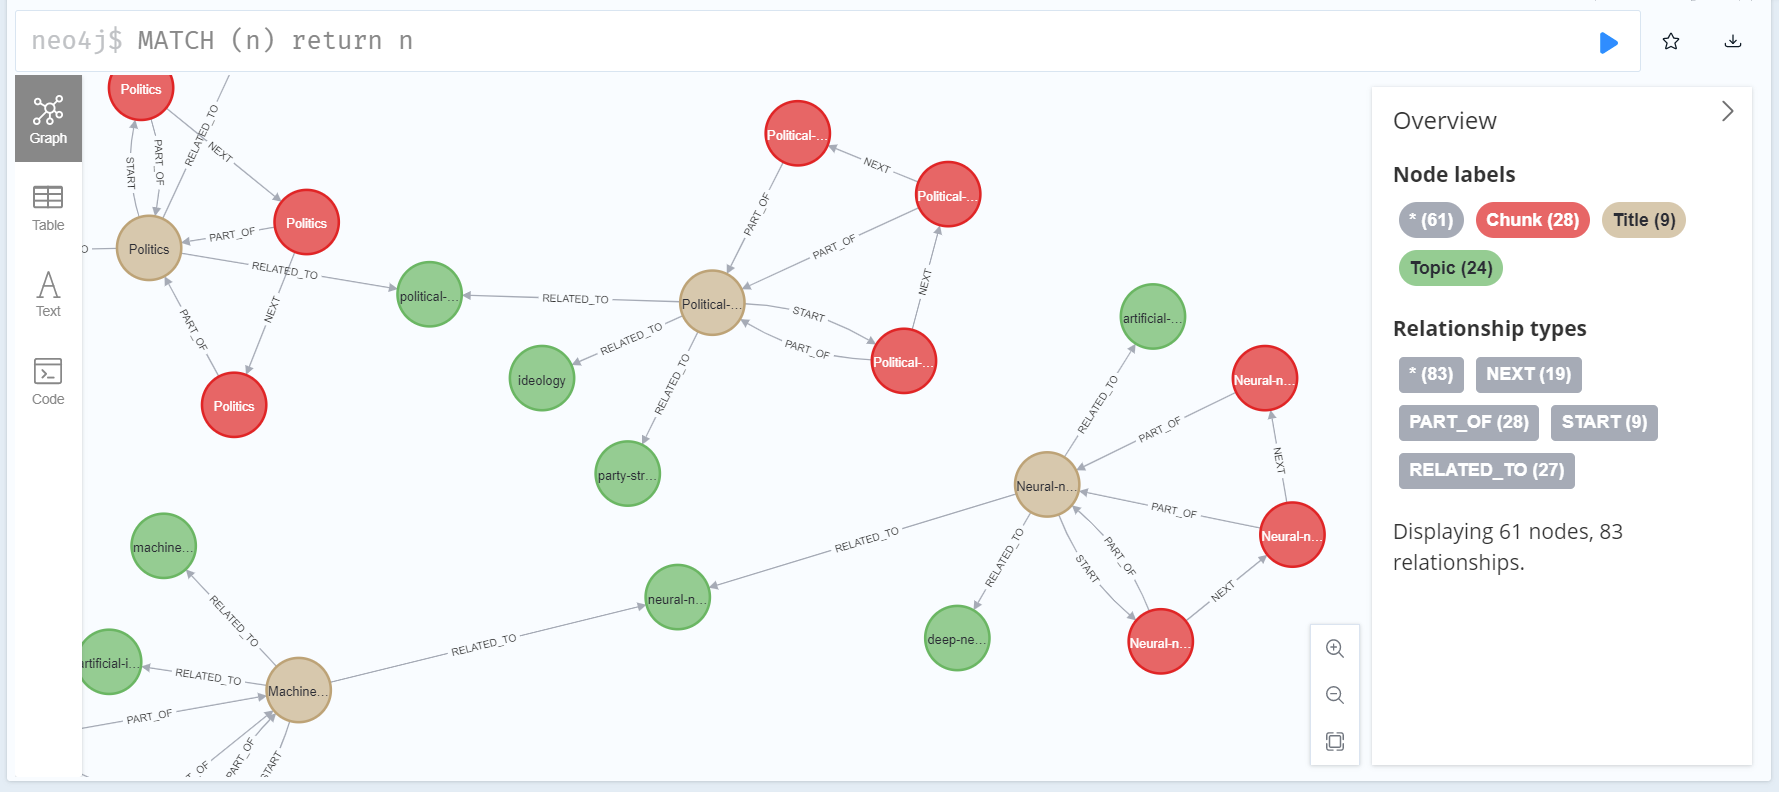

In [78]:
cypher = """
   MATCH (t:Title)-[:RELATED_TO]->(top:Topic) 
  RETURN t.title, t.source, top LIMIT 10

  """

result = kg.query(cypher)
result

[{'t.title': 'Machine-learning',
  't.source': 'https://en.wikipedia.org/wiki/Machine_learning',
  'top': {'name': 'machine-learning'}},
 {'t.title': 'Machine-learning',
  't.source': 'https://en.wikipedia.org/wiki/Machine_learning',
  'top': {'name': 'neural-networks'}},
 {'t.title': 'Machine-learning',
  't.source': 'https://en.wikipedia.org/wiki/Machine_learning',
  'top': {'name': 'artificial-intelligence'}},
 {'t.title': 'Quantum-machine-learning',
  't.source': 'https://en.wikipedia.org/wiki/Quantum_machine_learning',
  'top': {'name': 'classical-machine-learning-applied-to-quantum-experiments'}},
 {'t.title': 'Quantum-machine-learning',
  't.source': 'https://en.wikipedia.org/wiki/Quantum_machine_learning',
  'top': {'name': 'quantum-machine-learning'}},
 {'t.title': 'Quantum-machine-learning',
  't.source': 'https://en.wikipedia.org/wiki/Quantum_machine_learning',
  'top': {'name': 'quantum-computing'}},
 {'t.title': 'Neural-network-(machine-learning)',
  't.source': 'https://e